# Exercise 4a

In [91]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import matplotlib.pyplot as plt
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('pattern')
nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alberto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alberto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alberto\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading pattern: Package 'pattern' not found in
[nltk_data]     index
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Alberto\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Define Constants

In [92]:
filename = 'Corpus4a_Article_Hard' #Select the file contains the corpus
AGGREGATION_FACTOR=3 #Used to select how many phrase in each paragraph
SPLIT_NUMBER = 3 #Define how many split the algorithm must do in the corpus

## Define Functions

In [93]:
#Used to split the corpus in phrases
def chunking(file):
    with open(file, 'r', encoding='utf-8') as file:
        testo = file.read()
    phrases = re.split(r'\. |\n', testo) #ReGex split for each . and new line
    return phrases

#Used to elaborate each phrase in corpus
def elaborate_corpus(corpus):
    result = []
    for phrase in corpus:
        result.append(' '.join(lemmatized_tokens(phrase)))
    return result

#Lemmatize phrase and set all verb in infinitive form
def lemmatized_tokens(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    lemmas = []
    for token, tag in pos_tag(tokens):
        if token.isalpha() and token not in stop_words:
            if tag.startswith('VB'):
                lemmas.append(lemmatizer.lemmatize(token, pos='v'))
            else:
                lemmas.append(lemmatizer.lemmatize(token))
    return lemmas

#Use spaCy library to calculate the embedding of each phrase of the corpus
def calc_embedding(phrases):
    result = []
    nlp = spacy.load('en_core_web_lg')
    for phrase in phrases:
        doc = nlp(phrase)
        result.append(doc.vector)
    return result

def phrase_aggregator(corpus):
    paragraph = []
    for i in range(0, len(corpus), AGGREGATION_FACTOR):
        paragraph.append(' '.join((corpus[i:i + AGGREGATION_FACTOR])))
    return paragraph


# ETL
Elaborate, Transform and Load Dataset

In [94]:
corpus = phrase_aggregator(elaborate_corpus(chunking(filename)))

## Basic Approach
Using basic approach to calculate similarity between contiguous paragraphs as cosine similarity between relative embeddings and visualize it

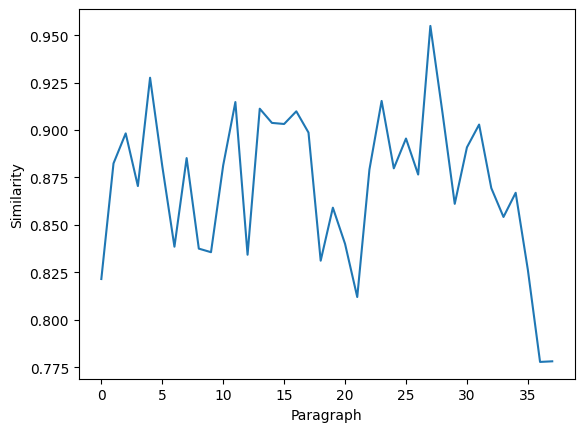

In [95]:
def calc_basic_similarity_metrics(corpus):
    embeddings = calc_embedding(corpus)
    similarity = []
    for index, embed in enumerate(embeddings):
        if index < len(embeddings) - 1:
            similarity.append(cosine_similarity([embed], [embeddings[index + 1]])[0][0])

    return similarity[:len(similarity)-1]

#calculate array of similarity
similarity_basic = calc_basic_similarity_metrics(corpus)

#Plot
plt.plot(range(len(similarity_basic)), similarity_basic)
plt.xlabel('Paragraph')
plt.ylabel('Similarity')
plt.show()

Select the split as minimal value of similarity

In [96]:
print("Split in position:",np.argsort(similarity_basic[0:len(similarity_basic)])[:SPLIT_NUMBER])
for index in np.argsort(similarity_basic[1:len(similarity_basic) - 1])[:SPLIT_NUMBER]:
    print("Last paragraph of split:",corpus[index],"\n")

Split in position: [36 37 21]
Last paragraph of split: base run involves calculate risk player time steal slide gain advantage defensively player must anticipate hit react swiftly execute precise throw catch make out prevent run throughout history baseball give rise countless iconic moment legendary player 

Last paragraph of split: game initially play rugged terrain use handmade club leather ball time evolve sophisticated sport standardized rule specialized equipment prestigious tournament core golf game strategy finesse 

Last paragraph of split: baseball sport require physical prowess mental acuity pitcher strategically choose pitch deceive batter employ variety technique like fastball curveballs batter must analyze pitch speed trajectory location make decision whether swing 



## Advanced Approach

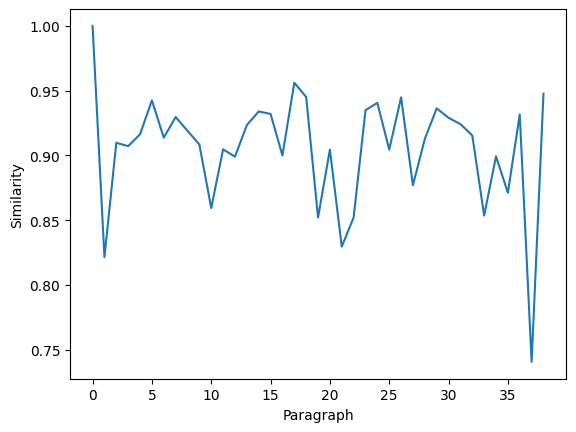

In [97]:
def calc_prototype_similarity_metrics(corpus):
    embeddings = calc_embedding(corpus)
    prototype=[]
    count=0
    similarity = []
    for index, embed in enumerate(embeddings):
        if len(prototype) == 0:
            prototype=embed
            similarity.append(1)
            count=1
        elif len(prototype) > 0:
            protoSim=cosine_similarity([embed], [prototype])[0][0]
            similarity.append(protoSim)
            if index < len(embeddings)-1 and protoSim < (cosine_similarity([embed], [embeddings[index + 1]])[0][0])-0.2:
                count=1
                prototype = embed
            else:
                prototype = (prototype*count+embed)/(count+1)
                count+=1

    return similarity[:len(similarity)-1]

#calculate array of similarity
similarity_advanced = calc_prototype_similarity_metrics(corpus)

#Plot
plt.plot(range(len(similarity_advanced)), similarity_advanced)
plt.xlabel('Paragraph')
plt.ylabel('Similarity')
plt.show()

In [98]:
splits = np.argsort(similarity_advanced[0:len(similarity_advanced)])[:SPLIT_NUMBER]
print("Split in position:", splits)
for index in np.argsort(similarity_advanced[1:len(similarity_advanced) - 1])[:SPLIT_NUMBER]:
    print("Last paragraph of split:", corpus[index], "\n")

Split in position: [37  1 21]
Last paragraph of split: babe ruth mighty home run jackie robinson break color barrier moment leave indelible mark sport fan world series pinnacle professional baseball showcases best team compete ultimate title captivate audience high stake dramatic performance baseball hero like willie may hank aaron derek jeter become symbol excellence inspire generation player fan alike 

Last paragraph of split: football also know soccer part world globally adored sport capture heart mind million rich history passionate fan base football become unifying force bring people diverse culture background together originate england century football quickly spread across continent captivate player spectator alike 

Last paragraph of split: game initially play rugged terrain use handmade club leather ball time evolve sophisticated sport standardized rule specialized equipment prestigious tournament core golf game strategy finesse 

